## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

## Loading & Processing Dataset

In [ ]:
wine_data = load_wine(as_frame=True)
wine_df = wine_data.frame
print(wine_df.head())
print("Shape of the Wine DataFrame:", wine_df.shape)

X = wine_df.drop('target', axis=1).values
y = wine_df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

## Defining NN Arc. for Clustering

In [ ]:
class StochasticClusteringNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(StochasticClusteringNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, z, mu, logvar

## Loss Function

In [ ]:
def loss_function(x_reconstructed, x, mu, logvar, beta=1.0):
    reconstruction_loss = nn.MSELoss()(x_reconstructed, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + beta * kl_loss

## Model Training

In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 64
latent_dim = 32
model = StochasticClusteringNN(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 32
early_stopping_patience = 10
best_loss = float('inf')
early_stopping_counter = 0

log_file = open("training_log.txt", "w")

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.shape[0])
    epoch_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = torch.tensor(X_train[indices], dtype=torch.float32)

        x_reconstructed, z, mu, logvar = model(batch_x)
        loss = loss_function(x_reconstructed, batch_x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        log_file.write(f"Epoch [{epoch+1}/{epochs}], Batch {i//batch_size+1}, Loss: {loss.item():.4f}\n")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered!")
        break

log_file.close()

Early stopping triggered!


## Evaluation (NN + KMeans)

In [ ]:
model.eval()
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    _, z_train, _, _ = model(X_train_tensor)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(z_train.numpy())
y_pred = kmeans.labels_

silhouette = silhouette_score(X_train, y_pred)
ari = adjusted_rand_score(y_train, y_pred)
nmi = normalized_mutual_info_score(y_train, y_pred)

print(f"Custom Model -> \nSilhouette: {silhouette:.4f} \nARI: {ari:.4f} \nNMI: {nmi:.4f}")

Custom Model -> 
Silhouette: 0.1520 
ARI: 0.3593 
NMI: 0.4186


## Uncertainty Quantification

In [ ]:
num_samples = 10
all_preds = []
with torch.no_grad():
    for _ in range(num_samples):
        _, z_train, _, _ = model(X_train_tensor)
        kmeans = KMeans(n_clusters=3, random_state=42).fit(z_train.numpy())
        all_preds.append(kmeans.labels_)
all_preds = np.array(all_preds)
uncertainty = np.mean(np.var(all_preds, axis=0))
print(f"Uncertainty: {uncertainty:.4f}")

Uncertainty: 0.4885


## Baselines (KMeans, GMM, SOM)

In [ ]:
# KMeans on raw features
baseline_kmeans = KMeans(n_clusters=3, random_state=42).fit(X_train)
baseline_labels = baseline_kmeans.labels_
baseline_ari = adjusted_rand_score(y_train, baseline_labels)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42).fit(X_train)
gmm_labels = gmm.predict(X_train)

# Self Organizing Map
class SOM:
    def __init__(self, grid_size, input_dim, learning_rate, n_iterations):
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = np.random.rand(grid_size[0], grid_size[1], input_dim)

    def find_bmu(self, x):
        distances = np.sum((self.weights - x)**2, axis=2)
        return np.unravel_index(np.argmin(distances), distances.shape)

    def update_weights(self, x, bmu_index, learning_rate, neighborhood_radius):
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                neuron_distance = np.sqrt((i - bmu_index[0])**2 + (j - bmu_index[1])**2)
                if neuron_distance <= neighborhood_radius:
                    influence = np.exp(-neuron_distance**2 / (2 * neighborhood_radius**2))
                    self.weights[i, j, :] += learning_rate * influence * (x - self.weights[i, j, :])

    def train(self, X):
        initial_learning_rate = self.learning_rate
        initial_neighborhood_radius = max(self.grid_size) / 2.0
        for iteration in range(self.n_iterations):
            learning_rate = initial_learning_rate * (1 - iteration / self.n_iterations)
            neighborhood_radius = initial_neighborhood_radius * np.exp(-iteration / self.n_iterations)
            for x in X:
                bmu_index = self.find_bmu(x)
                self.update_weights(x, bmu_index, learning_rate, neighborhood_radius)

    def cluster(self, X):
        labels = []
        for x in X:
            bmu_index = self.find_bmu(x)
            labels.append(bmu_index[0] * self.grid_size[1] + bmu_index[1])
        return np.array(labels)

som = SOM(grid_size=(10, 10), input_dim=input_dim, learning_rate=0.1, n_iterations=1000)
som.train(X_train)
som_labels = som.cluster(X_train)

## Unified Metrics Table

In [ ]:
def compute_stability(model_func, X, n_clusters=3, num_samples=10, is_som=False):
    # Run clustering multiple times and compute variance of cluster assignments.
    all_preds = []
    for seed in range(num_samples):
        if is_som:
            # Re-train SOM with different initialization
            som = SOM(grid_size=(10, 10), input_dim=X.shape[1],
                      learning_rate=0.1, n_iterations=500)
            som.train(X)
            preds = som.cluster(X)
        else:
            if model_func == GaussianMixture:
                model = model_func(n_components=n_clusters, random_state=seed).fit(X)
            else:
                model = model_func(n_clusters=n_clusters, random_state=seed).fit(X)
            preds = model.predict(X) if hasattr(model, "predict") else model.labels_
        all_preds.append(preds)
    all_preds = np.array(all_preds)
    return np.mean(np.var(all_preds, axis=0))

# Custom Model stability
custom_stability = uncertainty

# KMeans stability
kmeans_stability = compute_stability(KMeans, X_train, n_clusters=3)

# GMM stability
gmm_stability = compute_stability(GaussianMixture, X_train, n_clusters=3)

# SOM stability
som_stability = compute_stability(None, X_train, n_clusters=3, is_som=True)

# Recompute metrics for SOM
som_silhouette = silhouette_score(X_train, som_labels)
som_ari = adjusted_rand_score(y_train, som_labels)
som_nmi = normalized_mutual_info_score(y_train, som_labels)

# Build unified metrics table
metrics_data = {
    'Metric': ['Silhouette', 'ARI', 'NMI', 'Stability'],
    'Custom Model': [silhouette, ari, nmi, custom_stability],
    'KMeans': [
        silhouette_score(X_train, baseline_labels),
        baseline_ari,
        normalized_mutual_info_score(y_train, baseline_labels),
        kmeans_stability
    ],
    'GMM': [
        silhouette_score(X_train, gmm_labels),
        adjusted_rand_score(y_train, gmm_labels),
        normalized_mutual_info_score(y_train, gmm_labels),
        gmm_stability
    ],
    'SOM': [som_silhouette, som_ari, som_nmi, som_stability]
}
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Metric,Custom Model,KMeans,GMM,SOM
0,Silhouette,0.151979,0.275308,0.269447,-0.020585
1,ARI,0.359316,0.829260,0.784437,0.032038
2,NMI,0.418614,0.822972,0.773239,0.402579
3,Stability,0.488548,0.591613,0.592258,974.898952


## Visual Comparisons

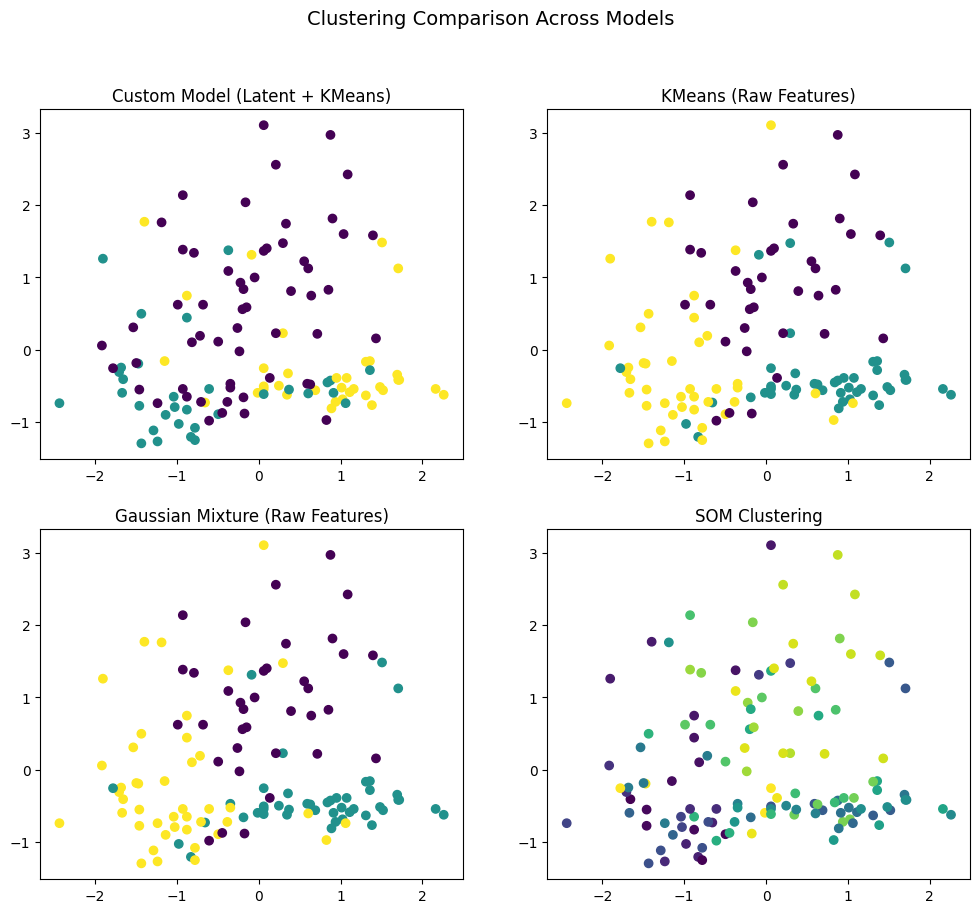

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0,0].scatter(X_train[:, 0], X_train[:, 1], c=y_pred, cmap='viridis')
axs[0,0].set_title("Custom Model (Latent + KMeans)")

axs[0,1].scatter(X_train[:, 0], X_train[:, 1], c=baseline_labels, cmap='viridis')
axs[0,1].set_title("KMeans (Raw Features)")

axs[1,0].scatter(X_train[:, 0], X_train[:, 1], c=gmm_labels, cmap='viridis')
axs[1,0].set_title("Gaussian Mixture (Raw Features)")

axs[1,1].scatter(X_train[:, 0], X_train[:, 1], c=som_labels, cmap='viridis')
axs[1,1].set_title("SOM Clustering")

plt.suptitle("Clustering Comparison Across Models", fontsize=14)
plt.show()